<a href="https://colab.research.google.com/github/NDU-CSC413/cuda1/blob/master/cuda1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Google colab creates a Linux instance that can be accesses from a Jupyter notebook. A Jupyter notebook consists of a sequence of cells. For our purpose there are two types of cells: **code** and **text**. For both cases you can "execute" the cell by pressing SHIFT-ENTER. For a text cell it will format it. You can always edit a text cell by double-clicking it.
A code cell executes Python by default. In our case we would like to edit c++ (with CUDA extensions) files, compile and run them.

First make sure that the runtime is GPU. From the menu choose Runtime->change runtime type-> Hardware accelerator choose GPU.

We can run arbitrary shell commands by either preceding each one of them with a "!" or we can use the magic characters "%%bash" in the begining of the cell.

As a first example let us determine the type of GPU that the instance has using the nvidia-smi command

In [ ]:
%%bash
nvidia-smi

Mon Apr  4 08:43:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Example 0: Querying the device

In [ ]:
%%writefile device.cu
#include <iostream>


int main()
{
	int device;

	cudaDeviceProp properties;
	cudaError_t err = cudaSuccess;
	err = cudaGetDevice(&device);
	err = cudaGetDeviceProperties(&properties, device);
	std::cout << "processor count" << properties.multiProcessorCount << std::endl;
	std::cout << "warp size " << properties.warpSize << std::endl;
	std::cout << "name=" << properties.name << std::endl;
	std::cout << "Compute capability " << properties.major << "." << properties.minor << "\n";
	std::cout << "shared Memory/SM " << properties.sharedMemPerMultiprocessor
		<< std::endl;

	if (err == cudaSuccess)
		printf("device =%d\n", device);
	else
		printf("error getting deivce\n");
	return 0;
}

Writing device.cu


In [ ]:
!nvcc -o device device.cu -run

processor count=40
warp size= 32
name=Tesla T4
Compute capability=7.5
shared Memory/SM=65536
device =0


## Example1

To write code, create a code cell and write %%writefile filename.cu at the beginning. To actually create/modify the file "run" the cell

In [ ]:
%%writefile example1.cu
#include <iostream>
__global__ void kernel(){
  printf("Hello from GPU\n");
}
int main(){
    kernel<<<1,2>>>();
    cudaDeviceSynchronize();

    
}

Writing example1.cu


At this point we can open the file from the left pane. Click on the folder icon in the left pane to see all the files.
Alternatively, we can list them using the unix "ls" command.

**IMPORTANT**: any file created from a Jupyter notebook will be lost once the instance is restarted.

A colab instance is a actually a VM running linux so each time it starts "from scratch". If you want to save files, mount your Google drive from the left pane.

In [ ]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Apr  4 08:44 .
drwxr-xr-x 1 root root 4096 Apr  4 08:37 ..
drwxr-xr-x 4 root root 4096 Mar 23 14:21 .config
-rw-r--r-- 1 root root  111 Apr  4 08:44 example1.cu
drwxr-xr-x 1 root root 4096 Mar 23 14:22 sample_data


CUDA code files MUST have the extension .cu, and it is compiled with the NVIDIA nvcc compiler

In [ ]:
!nvcc example1.cu -o example1 
!./example1

Hello from GPU
Hello from GPU


## Example2

Most of the examples in the workshop use **managed memory**. In the following examples we will manage the memory manually. We will revisit managed memory later.

Before computing on the GPU we need to transfer the data from host memory to device memory. Once the computation is done we transfer it back to the host.
Below is a simple example of that process.

NOTE: ```cudaMemcpy``` is **synchronous**, meaning the host code will **block** until the memory transfer is complete.





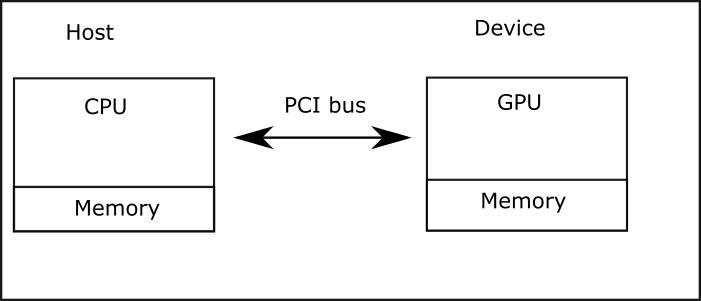

In [ ]:
%%writefile example2.cu
#include <iostream>
__global__ void kernel(int *x,int *y,int *z){
    *z=*x+*y;
}
int main(){
    int a=1,b=2,c=0; //host variables
    int *d_a,*d_b,*d_c;//will hold device addresses
    // allocate memory for one integer and store the
     // address in d_a 
    cudaMalloc(&d_a,sizeof(int));
    cudaMalloc(&d_b,sizeof(int));
    cudaMalloc(&d_c,sizeof(int));
    // copy the value of a and b
    // TO device FROM host
    cudaMemcpy(d_a,&a,sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(d_b,&b,sizeof(int),cudaMemcpyHostToDevice);
    kernel<<<1,1>>>(d_a,d_b,d_c);
    // copy the result TO host FROM device
    cudaMemcpy(&c,d_c,sizeof(int),cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();
    
std::cout<<"value of c is "<<c<<"\n";
    
}

Writing example2.cu


In [ ]:
!nvcc example2.cu -o example2
!./example2

value of c is 3


# More details
Below is a similar code but with more details. In particular, it describes what and what cannot be accessed from the device and explains the \_\_device\_\_ and \_\_global\_\_ modifiers.

In [ ]:
%%writefile example3.cu
#include <iostream>

/**
 * @brief constant global variables are accessible from both the CPU and GPU.
 * if the constant modified is removed from the declaration of g the compiler 
 * will give an error.
 * NOTE: global variables in the sense of C++ are DIFFERENT than the __global__ 
 * modifier.
 * NOTE: GPU access of const global variables other than int in Windows gives an error
 * on Linux it works. 
 */
const int g=10;
#ifdef WINDOWS
__device__ 
#endif 
const float a=2.3;

/* __device__ means a function called from the device
* AND runs on the device
*/

__device__ float useless(){
    return 2*a;
}

/* __global__ means a function called from the host 
 * and runs on device
 */
__global__ void example1(int *address){
    *address=useless()*g*17;

}


int main(){
    int x;
    /* variable that holds device address */
    int * device_address;
    /* allocate space for one int on the device 
     * and store the allocated address in device_address
     * NOTE the passing of the address of device_address variable
     */
    cudaMalloc(&device_address,sizeof(int));
    /* set the value at device address to 17 using a kernel launch*/
    std::cout<<"address of x="<<std::hex<<&x<<"\n";
    std::cout<<"device address="<<device_address<<"\n";
    /* launch function example1 with one block containing 1 thread 
     * @NOTE: all kernel launches are asynchronous
     * they return immediately to host code
     **/
    example1 <<<1,1>>>(device_address);
    /* copy the result back from device to host */
    cudaMemcpy(&x,device_address,sizeof(int),cudaMemcpyDeviceToHost);
    cudaFree(device_address);
    std::cout<<"The value of x="<<std::dec<<x<<"\n";

}

Writing example3.cu


## Example4
This is the first example where we use parallelism, computing the sum of two arrays.
The computation is performed where each thread computes the sum of two elements. To accomplish that we map the thread id to the array index. In this example we use a __single__, __linear__, block therefore the thread id is equal to the builtin variable threadIdx.x

# Thread Hierarchy and Stream Multiprocessors

A CUDA device contains an array of streaming multiprocessors (SM).In the CUDA programming model, threads are organized into thread blocks. Each thread block runs independently on a different SM.

Note: the assignment of blocks to SMs is static. Once the blocks are assigned to SMs they will not move even if some SMs finish running their blocks and become idle.

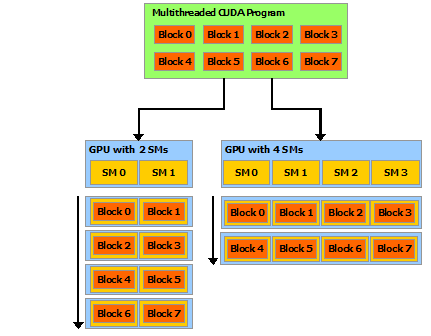

The threads in a kernel execution is organized in a hierarchy. The totality of the threads is called a **grid**. A grid is composed of **blocks** and each block is composed of **threads**.

Below is an example of a **linear** grid. In general the blocks and threads can be organized in 3-d.

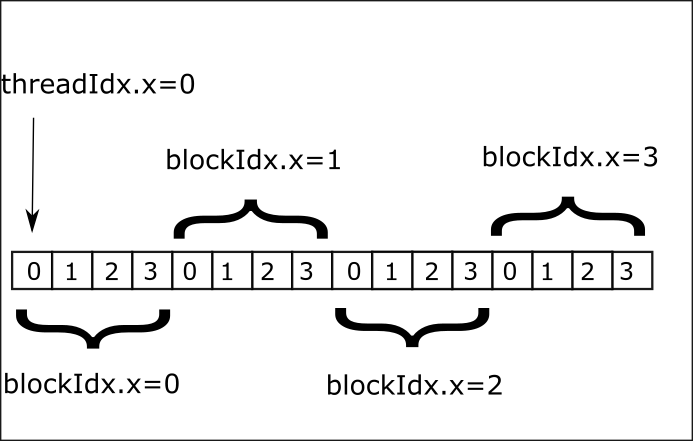

In [5]:
%%writefile example4.cu
/**
 * @file example4.cu
 * @author Hikmat Farhat (hfarhat@ndu.edu.lb)
 * @brief SAXPY example in CUDA
 * given vectors X and Y and a constant a compute a*X+Y
 * @version 0.1
 * @date 2021-12-20
 * 
 * @copyright Copyright (c) 2021
 * 
 */
#include <iostream>


__global__ void saxpy(float *z,float *x,float *y,float a,int n){
   
     int i=blockDim.x*blockIdx.x+threadIdx.x;
     if( i<n)
        z[i]=a*x[i]+y[i];

}
int main(){
    /* number of elements */
    const int n=1<<20;
    const float a=3.0;
/* create 3 arrays on host */
    float *x, *y, *z;
    x=(float *)malloc(n*sizeof(float));
    y=(float *)malloc(n*sizeof(float));
    z=(float *)malloc(n*sizeof(float));
/* populate x and y */
    for(int i=0;i<n;++i){
        x[i]=2;
        y[i]=4;
    }
/* create 3 arrays on device */
    float *dx,*dy,*dz;
    cudaMalloc(&dx,n*sizeof(float));
    cudaMalloc(&dy,n*sizeof(float));
    cudaMalloc(&dz,n*sizeof(float));
/* transfer the values of x,y to device */
    cudaMemcpy(dx,x,n*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(dy,y,n*sizeof(float),cudaMemcpyHostToDevice);
    /** 1-d grid 
     * in general type dim3 has 3 values (x,y,z)
     * when omitted each d defaults to 1
     * e.g. dim3 a(256)=a(256,1,1)
     * dim3 b(256,128)=b(256,128,1)
     ***/
     int block=256;
     int grid=(n+block-1)/block;
    //dim3 block (256);
    //dim3 grid ((n+block.x-1)/block.x,1);
    /**
     * NOTE:  kernel launch is asynchronous with respect
     * to host code whereas cudaMemcpy is blocking.
     */
    saxpy<<<grid,block>>>(dz,dx,dy,a,n); 
    saxpy<<<grid,block>>>(dz,dx,dy,a,n); 

    cudaError_t e=cudaGetLastError();
    if(e!=cudaSuccess){
        std::cout<<cudaGetErrorString(e)<<"\n";
    }
/* transfer the result back to host */
    cudaMemcpy(z,dz,n*sizeof(float),cudaMemcpyDeviceToHost);
/* check if the result is correct. We expect all values 
 * of z=10
 */
    int sum=0;
    for(int i=0;i<n;++i)
        sum+=z[i];
    if (sum!=n*10)std::cout<<"sum error"<<sum<<"\n";
    else
        std::cout<<"check passed. Sum= "<<sum<<"\n";
    free(x);
    free(y);
    free(z);
    cudaFree(dx);
    cudaFree(dy);
    cudaFree(dz);
}

Overwriting example4.cu


In [6]:
!nvcc example4.cu -o example4 -run

check passed. Sum= 10485760


# Thread Id mapping

So far we have mapped a thread id to its index in a linear fashion. For convenience, CUDA allows us to organize the threads in 2-d and 3-d.
For 2-d, if the block is of size $(D_x,D_y)$ and the index of a thread is $(x,y)$ then its id is

$$id=x+y\cdot D_x$$

**NOTE**:  for consistancy with the 1-d representation, and unlike the usual matrix indexing, the $x$ dimension refers to the column and $y$ refers to the row. A example mapping is shown in the figure below.

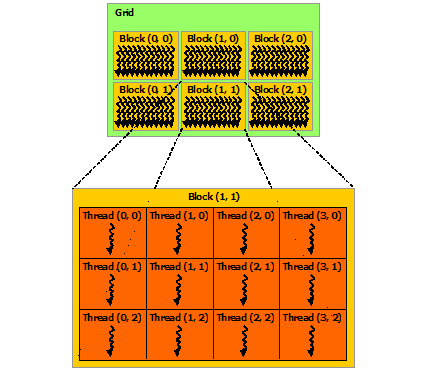

# dim3
CUDA defines a ```dim3``` type that has 3 components. For example

```dim3 block(2,2,2)``` 

is a 3-d organization of threads in a block. We can refer to each dimension with ```block.x```,```block.y```,```block.x```

Furthermore, any omitted dimension defaults to 1. For example
```dim3 block(2,2)``` is equivalent to ```dim3 block(2,2,1)```
and
```dim3 block(2)``` is equivalent to ```dim3 block(2,1,1)```

### Matrix addition
We illustrate the used of 2-d organization of the blocks and threads with a simple example of matrix addition.

In [ ]:
%%writefile example6.cu
/**
 * @file example5.cu
 * @author Hikmat Farhat (hfarhat@ndu.edu.lb)
 * @brief Simple matrix addition
 * @version 0.1
 * @date 2021-12-30
 * 
 * @copyright Copyright (c) 2021
 * 
 */
#include <iostream>
const size_t width=1024;
const size_t height=1024;

//typedef float arr_t[width];
using arr_t = float[width];
__global__ void matrix_add(arr_t *c,arr_t *a,arr_t *b,size_t width,size_t height){

    size_t idx=blockIdx.x*blockDim.x+threadIdx.x;
    size_t idy=blockIdx.y*blockDim.y+threadIdx.y;
    if( idx<width && idy <height)
        //c[idx][idy]=a[idx][idy]+b[idx][idy];
        c[idy][idx]=a[idy][idx]+b[idy][idx];
}
int main(){
    arr_t *a,*b,*c;
    cudaMallocManaged(&a,height*sizeof(arr_t));
    cudaMallocManaged(&b,height*sizeof(arr_t));
    cudaMallocManaged(&c,height*sizeof(arr_t));
    for(size_t i=0;i<width;++i){
        for(size_t j=0;j<height;++j){
            a[i][j]=1;
            b[i][j]=2;
        }
    }
    dim3 block(32,32);
    dim3 grid(width/block.x+1,  height/block.y+1);    
    matrix_add<<<grid,block>>>(c,a,b,width,height);
    cudaDeviceSynchronize();
    bool e=false;
    for(size_t i=0;i<width;++i)
        for(size_t j=0;j<height;++j)
            if(c[i][j]!=3){
                e=true;
                break;
            }
    if (e==true)std::cout<<"error\n";
}

Writing example6.cu


# Mempry Hierarchy
The figure below shows the memory hierarchy for a typical NVIDIA GPU. Scalar variables without qualifiers are stored in registers, arrays in global/local memory. Variables preceded with __shared__ and __constant__ are stored in shared and constant memory respectively.

What concerns us in this section is that shared memory, being on chip (typically 64KB), is much faster to access than DRAM.


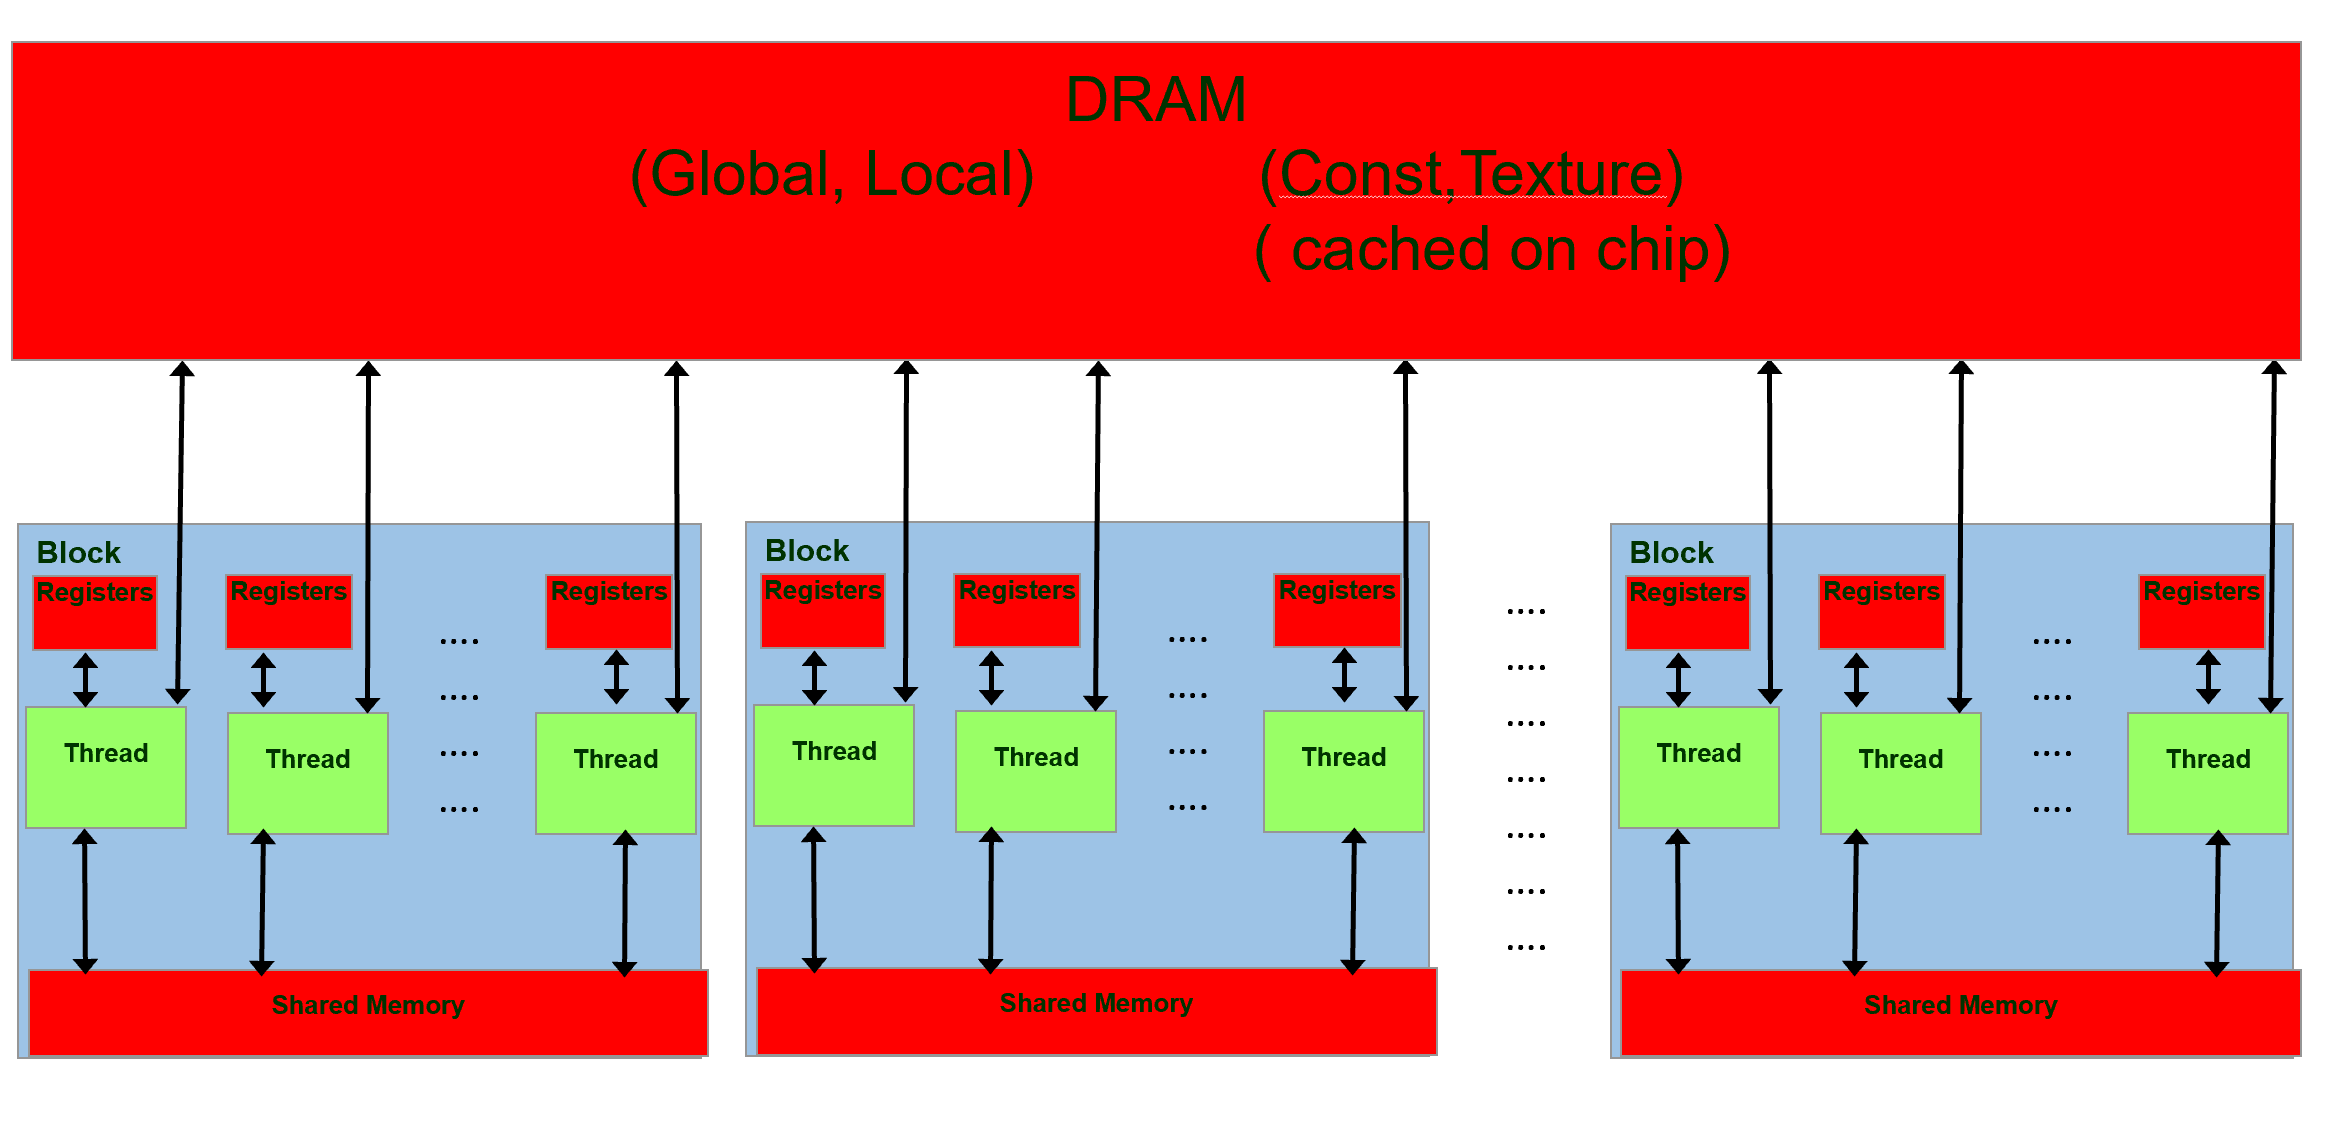

The figure above gives a clear picture of the way blocks are handled, each block runs independently on an SM. An important intrinsic primitive provided by CUDA is the __syncthread() call. It acts like a barrier for all threads in a block.

We will illustrate the above concepts with an implementation of the reduce operation. It is easier to visualize the reduce operation as a binary tree as in the example below.

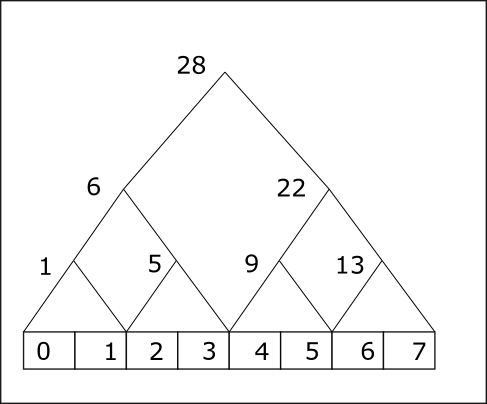

In [ ]:
%%writefile example7.cu
#include <iostream>

#define THREADS_PER_BLOCK 1024

__global__ void reduction(int* da, int* db) {
	__shared__ int sdata[THREADS_PER_BLOCK];
	unsigned int tid = threadIdx.x;
	unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;
	sdata[tid] = da[i];
	__syncthreads();
	// do reduction in shared mem
	
	for (unsigned int stride = 1; stride < blockDim.x; stride *= 2) {
		if (tid % (2 * stride) == 0) {
			sdata[tid] += sdata[tid + stride];
		}
		__syncthreads();
	}
	// write result for this block to global mem
	if (tid == 0) db[blockIdx.x] = sdata[0];
	
}



int main() {
	/* we are using a 1-d grid. Max grid size is 65536 x 65536 x 65536*/
	const int n = 1 << 10;
	int *a;
	int *c;
	const int blocks_per_grid = n/THREADS_PER_BLOCK;
	
	int b[blocks_per_grid];
	a = (int*)malloc(n * sizeof(int));
	c = (int*)malloc(n * sizeof(int));
	for (int i = 0; i < n; i++) {
		a[i] = 2; c[i] = 3;
	}
	int* da,*dc;
	int* db;
	
	std::cout << "blocks per grid "<<blocks_per_grid << "\n";
	cudaMalloc(&da, n * sizeof(int));
	cudaMalloc(&db, blocks_per_grid * sizeof(int));
	cudaMemcpy(da, a, n * sizeof(int), cudaMemcpyHostToDevice);
	
	cudaEvent_t start, end;
	cudaEventCreate(&start);
	cudaEventCreate(&end);
	const int num_trials = 500;
	float total1 = 0, time = 0;
	for (int i = 0; i < num_trials; ++i) {
		cudaEventRecord(start, 0);
		reduction<<<blocks_per_grid, THREADS_PER_BLOCK >> > (da, db);
		cudaEventRecord(end, 0);
		cudaEventSynchronize(end);
		cudaEventElapsedTime(&time,start,end);
		total1 += time;
	}
	std::cout << "average duration =" << total1 / num_trials << "\n";
	
	cudaMemcpy(b, db, blocks_per_grid * sizeof(int), cudaMemcpyDeviceToHost);
	int sum = 0;
	for (int i = 0; i <blocks_per_grid; ++i)
		sum += b[i];
	std::cout <<"total= "<<sum<<"\n";
	cudaFree(da);
	cudaFree(db);
	cudaFree(dc);



}


Overwriting example7.cu
